# Predicting the Fluorination Strenght of Electrophilic Fluorinating Reagents
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/prediction-fluorination-strength/notebooks/data-preprocessing-1.ipynb)

This projects aims to reproduce a publication of 2022 ["Machine Learning Approach for Predicting the Fluorination Strenght of Electrophilic Fluorinating Reagents"](https://doi.org/10.1039/d2cp03281c).

Here, the author, collected a 260 molecules with reliable dissociation energies (FPD) and created a novel SMILES-based dataset for a family of electrophiles as fluorinating reagents. The author used 2 solvents (DCM and MeCN) and divided the molecules in six categories (N-fluorosulfonimides, N-fluorosulfonamides, N-flurocarboxamides, N-fluoropyridiniums, N-fluoroheterocycles, and N-fluoroammoniums).

The following workflow was performed according with the named publication:
1. Calculation of molecular descriptor using Mordred.
2. Feature engineering:
    - 2.1 Elimination of missing values
    - 2.2 Correlation-based variable reduction
    - 2.3 Elimination of feature with constant values
3. One-hot encoding for the two solvents and the molecular categories.
4. Screening of the most popular ML algorithms using R^2 and RMSE as metrics, and five-fold cross validation procedure.
5. Predictions on the test set.

Here, I'll try to reproduce the reproducir the results presented in the titled publication.

## Import Libraries

In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.8 MB/s eta 0:00:00


In [2]:
!pip install mols2grid #to visualize in a grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00


In [3]:
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.7 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=92bf9ee88ceb306738f9274e0a845b86e43375673200d10480761f52f96c8e56
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10

In [4]:
!pip install openpyxl

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem #Chemistry related RDKit module
from rdkit.Chem.Draw import IPythonConsole #Molecules visualization with Jupyter
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency
from rdkit.Chem import PandasTools #RDKit with Pandas
import mols2grid #Molecule representation in a grid
from mordred import Calculator, descriptors #Collection of Mordred Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors #To generate Descriptors
IPythonConsole.ipython_useSVG = True #Molecules display in SGV in Jupyter
rdDepictor.SetPreferCoordGen(True) #Cleaner 2D coordinate generation

## Load Dataset

In [7]:
data = pd.read_excel("F260_raw.xlsx")
data.head()

,Name of the Reagent,Reagent ID Number,Type of Reagent,Solvent,Smiles,FPD
0,N-fluoro-N-(phenylsulfonyl)benzenesulfonamide,A1a,N-Fluorosulfonimides,MeCN,O=S(C1=CC=CC=C1)(N(S(C2=CC=C([H])C=C2)(=O)=O)F)=O,229.6
1,N-fluoro-N-(phenylsulfonyl)benzenesulfonamide,A1a,N-Fluorosulfonimides,DCM,O=S(C1=CC=CC=C1)(N(S(C2=CC=C([H])C=C2)(=O)=O)F)=O,242.4
2,N-fluoro-4-methoxy-N-(phenylsulfonyl)benzenesu...,A1b,N-Fluorosulfonimides,MeCN,O=S(C1=CC=CC=C1)(N(S(C2=CC=C(OC)C=C2)(=O)=O)F)=O,231.2
3,N-fluoro-4-methoxy-N-(phenylsulfonyl)benzenesu...,A1b,N-Fluorosulfonimides,DCM,O=S(C1=CC=CC=C1)(N(S(C2=CC=C(OC)C=C2)(=O)=O)F)=O,244.2
4,N-fluoro-4-methyl-N-(phenylsulfonyl)benzenesul...,A1c,N-Fluorosulfonimides,MeCN,O=S(C1=CC=CC=C1)(N(S(C2=CC=C(C)C=C2)(=O)=O)F)=O,230.3


- Name of the Reagent: The chemical name of the reagent.
- Reagent ID Number: An ID or code associated with each reagent.
- Type of Reagent: The classification or type of the reagent.
- Solvent: The solvent used.
- Smiles: The SMILES representation of the chemical structure.
- FPD: dissociation energy.

## Exploratory Data Analysis

### Statisticals - FPD

In [8]:
data['FPD'].describe()

count    260.000000
mean     234.637692
std       24.136736
min      110.900000
25%      223.775000
50%      231.200000
75%      246.925000
max      290.400000
Name: FPD, dtype: float64

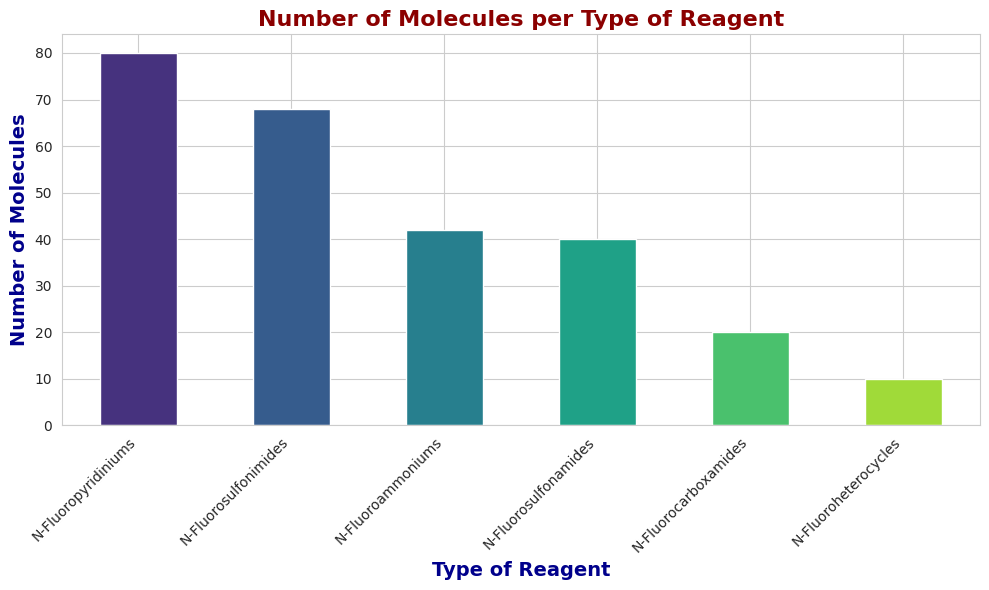

In [9]:
title_font = {"color" : "darkred", "weight" : "bold", "size" : 16}
axis_font = {"color" : "darkblue", "weight" : "bold", "size" : 14}

# Color palette from seaborn and style
sns.set_style("whitegrid")
colors = sns.color_palette('viridis', n_colors=len(data[' Type of Reagent'].unique()))

# Counting the number of molecules for each 'Type of Reagent'
type_counts = data[' Type of Reagent'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title('Number of Molecules per Type of Reagent', fontdict=title_font)
plt.xlabel('Type of Reagent', fontdict=axis_font)
plt.ylabel('Number of Molecules', fontdict=axis_font)
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.30)

# Save Plot
plt.savefig('molecules_categories.pdf')

# Display the plot
plt.tight_layout()
plt.show()

### Missing Values

In [10]:
missing_values = data.isnull().sum()
missing_values

Name of the Reagent    0
Reagent ID Number      0
 Type of Reagent       0
Solvent                0
Smiles                 0
FPD                    0
dtype: int64

### Unique Values

In [11]:
unique_values = data.nunique()
unique_values

Name of the Reagent    129
Reagent ID Number      132
 Type of Reagent         6
Solvent                  2
Smiles                 130
FPD                    214
dtype: int64

From here, we can see that Solvent and Type of Reagent are big candidates for one-hot encoding transformation before model traing.

## Molecules Visualization

In [12]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] # Chem.MolFromSmiles Convert a SMILES to an RDKit molecule object
    smiles = [Chem.MolToSmiles(mol) for mol in mols] # Chem.MolToSmiles converts the molecule back into its canonical SMILES representation
    return smiles

In [13]:
# Canonical SMILES
canon_smiles = canonical_smiles(data['Smiles'])

In [14]:
# Put the smiles in the dataframe
data['Smiles'] = canon_smiles
data

,Name of the Reagent,Reagent ID Number,Type of Reagent,Solvent,Smiles,FPD
0,N-fluoro-N-(phenylsulfonyl)benzenesulfonamide,A1a,N-Fluorosulfonimides,MeCN,O=S(=O)(c1ccccc1)N(F)S(=O)(=O)c1ccccc1,229.6
1,N-fluoro-N-(phenylsulfonyl)benzenesulfonamide,A1a,N-Fluorosulfonimides,DCM,O=S(=O)(c1ccccc1)N(F)S(=O)(=O)c1ccccc1,242.4
2,N-fluoro-4-methoxy-N-(phenylsulfonyl)benzenesu...,A1b,N-Fluorosulfonimides,MeCN,COc1ccc(S(=O)(=O)N(F)S(=O)(=O)c2ccccc2)cc1,231.2
3,N-fluoro-4-methoxy-N-(phenylsulfonyl)benzenesu...,A1b,N-Fluorosulfonimides,DCM,COc1ccc(S(=O)(=O)N(F)S(=O)(=O)c2ccccc2)cc1,244.2
4,N-fluoro-4-methyl-N-(phenylsulfonyl)benzenesul...,A1c,N-Fluorosulfonimides,MeCN,Cc1ccc(S(=O)(=O)N(F)S(=O)(=O)c2ccccc2)cc1,230.3
...,...,...,...,...,...,...
255,"(1R,2R,4S,5S)-2-((S)-acetoxy(6-methoxyquinolin...",F6c,N-Fluoroammoniums,DCM,CC[C@@H]1C[N@+]2(F)CC[C@H]1C[C@@H]2[C@@H](OC(C...,250.7
256,Dinitrogen Fluoride,F7,N-Fluoroammoniums,MeCN,N#[N+]F,110.9
257,Dinitrogen Fluoride,F7,N-Fluoroammoniums,DCM,N#[N+]F,112.3
258,Ammonium Fluoride,F8,N-Fluoroammoniums,MeCN,F[N+](F)(F)F,150.9


In [15]:
mol_list = [Chem.MolFromSmiles(element) for element in data['Smiles']]

In [16]:
len(mol_list)

260

In [17]:
# Creat a DataFrame from the mol_list
df_mol_list = pd.DataFrame(mol_list, columns=['Molecule'])

In [18]:
# Concatenating the dataframes
concatenated_df = pd.concat([df_mol_list, data[[' Type of Reagent', 'Solvent']]], axis=1)
concatenated_df

,Molecule,Type of Reagent,Solvent
0,<rdkit.Chem.rdchem.Mol object at 0x7f2da4ba3f40>,N-Fluorosulfonimides,MeCN
1,<rdkit.Chem.rdchem.Mol object at 0x7f2da4a8c2e0>,N-Fluorosulfonimides,DCM
2,<rdkit.Chem.rdchem.Mol object at 0x7f2da4a8c820>,N-Fluorosulfonimides,MeCN
3,<rdkit.Chem.rdchem.Mol object at 0x7f2da4a8c7b0>,N-Fluorosulfonimides,DCM
4,<rdkit.Chem.rdchem.Mol object at 0x7f2da4a8ceb0>,N-Fluorosulfonimides,MeCN
...,...,...,...
255,<rdkit.Chem.rdchem.Mol object at 0x7f2da30b4270>,N-Fluoroammoniums,DCM
256,<rdkit.Chem.rdchem.Mol object at 0x7f2da30b42e0>,N-Fluoroammoniums,MeCN
257,<rdkit.Chem.rdchem.Mol object at 0x7f2da30b4350>,N-Fluoroammoniums,DCM
258,<rdkit.Chem.rdchem.Mol object at 0x7f2da30b43c0>,N-Fluoroammoniums,MeCN


In [19]:
# Visualize the DataFrame of the molecules within a grid
mols2grid.display(concatenated_df, mol_col="Molecule", subset=[" Type of Reagent", "Solvent"])

MolGridWidget()

In [20]:
!pip install cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 5.0 MB/s eta 0:00:00


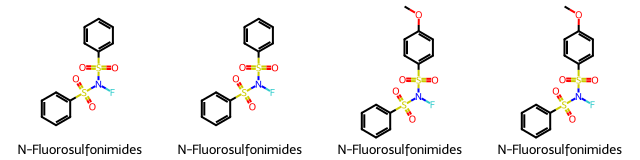

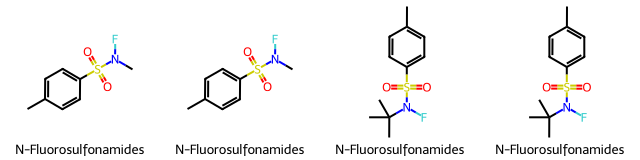

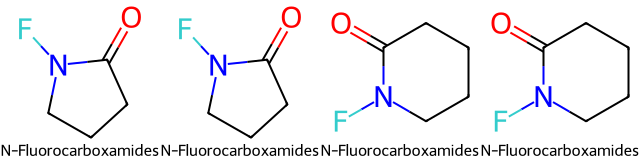

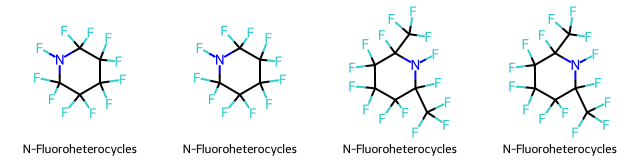

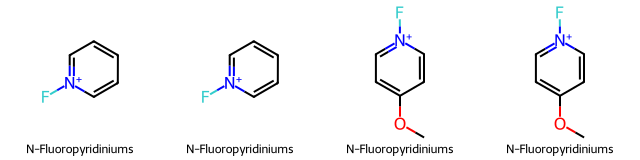

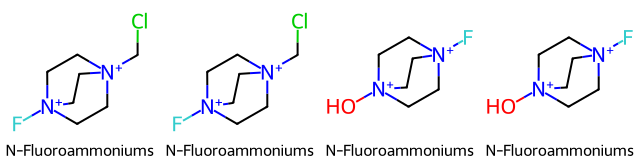

In [23]:
import cairosvg

# Get unique 'Type of Reagent' values
unique_reagents = concatenated_df[' Type of Reagent'].unique()

# Loop over each unique reagent type
for reagent in unique_reagents:

    # Filter the dataframe based on the current 'Type of Reagent'
    filtered_df = concatenated_df[concatenated_df[' Type of Reagent'] == reagent]

    # Get the legend
    legend = [reagent for _ in filtered_df["Molecule"][:4]]

    # Generate the grid image for the filtered molecules
    img = Draw.MolsToGridImage([x for x in filtered_df["Molecule"]][:4],
                               subImgSize=(160,160),
                               molsPerRow=4,
                               legends = legend)
    display(img)

    # Save the SVG image to a file
    svg_filename = f"molecules_for_{reagent}.svg".replace(" ", "_")  # Replace spaces with underscores for filename
    with open(svg_filename, "w") as f:
        f.write(img.data)

    # Convert the SVG to PDF
    pdf_filename = svg_filename.replace(".svg", ".pdf")
    cairosvg.svg2pdf(url=svg_filename, write_to=pdf_filename)

## Mordred Descriptors

In [24]:
def mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]

    # pandas df
    df = calc.pandas(mols)
    return df

In [25]:
mordred_descriptors = mordred_descriptors(data['Smiles'])

100%|██████████| 260/260 [01:04<00:00,  4.02it/s]


In [26]:
mordred_descriptors.shape

(260, 1826)

In [27]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,15.347868,13.774328,0,0,25.102645,2.478172,4.956344,25.102645,1.255132,3.915123,...,10.080922,54.025452,315.003528,10.500118,767,34,104.0,123.0,7.958333,4.333333
1,15.347868,13.774328,0,0,25.102645,2.478172,4.956344,25.102645,1.255132,3.915123,...,10.080922,54.025452,315.003528,10.500118,767,34,104.0,123.0,7.958333,4.333333
2,16.762082,14.726048,0,0,27.531935,2.482426,4.964851,27.531935,1.251452,4.006197,...,10.161496,56.461523,345.014093,10.147473,1038,38,114.0,135.0,9.069444,4.833333
3,16.762082,14.726048,0,0,27.531935,2.482426,4.964851,27.531935,1.251452,4.006197,...,10.161496,56.461523,345.014093,10.147473,1038,38,114.0,135.0,9.069444,4.833333
4,16.164365,14.313491,0,0,25.847729,2.481475,4.962950,25.847729,1.230844,3.963631,...,10.136383,55.302587,329.019178,9.970278,892,36,110.0,130.0,8.819444,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,22.034198,17.640259,0,1,36.497289,2.555561,5.111122,36.497289,1.303475,4.278231,...,10.566511,64.127058,387.207847,6.914426,1835,50,154.0,187.0,9.312500,6.138889
256,1.414214,1.414214,0,1,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,47.004003,15.668001,4,0,6.0,4.0,2.250000,1.000000
257,1.414214,1.414214,0,1,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,47.004003,15.668001,4,0,6.0,4.0,2.250000,1.000000
258,3.464102,3.464102,0,1,4.000000,2.000000,4.000000,4.000000,0.800000,2.444466,...,7.625107,29.418928,89.996138,17.999228,16,0,20.0,16.0,4.062500,1.000000


In [28]:
mordred_descriptors.to_excel('mordred_descriptors-F260_1826.xlsx', index=False)

### Missing Descriptors

In [32]:
# Identify columns with non-numerical values
non_numeric_columns = mordred_descriptors.select_dtypes(exclude=['number']).columns.tolist()

In [34]:
non_numeric_columns[:10]

['AATS3dv',
 'AATS4dv',
 'AATS5dv',
 'AATS6dv',
 'AATS7dv',
 'AATS8dv',
 'AATS3d',
 'AATS4d',
 'AATS5d',
 'AATS6d']

In [36]:
len(non_numeric_columns)

698

In [42]:
# Display the non-numeric columns and their unique values
non_numeric_info = {}
for col in non_numeric_columns:
    non_numeric_info[col] = mordred_descriptors[col].unique()

for key, value in list(non_numeric_info.items())[:1]:
    print(f"{key}: {value}")

AATS3dv: [7.838383838383839 7.934272300469484 7.324074074074074 8.535353535353536
 7.96969696969697 7.922558922558923 8.46078431372549 8.904761904761905
 8.017543859649123 6.888888888888889 4.616161616161616 9.232323232323234
 8.1010101010101 8.006734006734007 10.701754385964913 10.581196581196581
 9.561904761904762 9.855855855855856 4.5 11.975 8.788461538461538
 10.625468164794007 6.644444444444444 24.277777777777775
 31.977777777777774 32.88304093567251 33.2063492063492 30.196078431372552
 30.22222222222222 29.988304093567248 10.421052631578947 7.647058823529412
 6.0592592592592585 5.076023391812865 6.088888888888889 4.791666666666667
 3.7079365079365076 4.1440329218107 5.075757575757576 6.764367816091954
 8.112903225806452 30.342592592592595 3.110032362459547 3.169642857142857
 3.6019417475728157 4.797101449275363 4.426900584795322 5.2880658436214
 5.673913043478261 4.510703363914374 4.827586206896552 5.831501831501832
 7.3105022831050235 3.8888888888888884 3.2413793103448274 2.9
 2

In [43]:
# Drop columns that have non-numeric values
cleaned_mordred_descriptors = mordred_descriptors.drop(columns=non_numeric_columns)

# Display the shape of the cleaned dataframe
cleaned_mordred_descriptors.shape

(260, 1128)

### Correlation-based Variable Reduction

In [44]:
#Create the correlation matrix
correlation_matrix = cleaned_mordred_descriptors.corr(numeric_only=True)
correlation_matrix.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
ABC,1.000000,0.979309,-0.129095,-0.208555,0.987280,0.641578,0.684159,0.987280,0.166565,0.938680,...,0.770720,0.881886,0.968611,-0.035339,0.875479,0.955683,0.996124,0.985893,0.844411,0.987389
ABCGG,0.979309,1.000000,-0.110378,-0.302648,0.943047,0.697603,0.734753,0.943047,0.043160,0.940274,...,0.808092,0.889622,0.981656,0.075723,0.829545,0.976894,0.982816,0.979834,0.923563,0.958802
nAcid,-0.129095,-0.110378,1.000000,0.194610,-0.163680,-0.076726,-0.049002,-0.163680,-0.268130,-0.088647,...,-0.062312,-0.163139,-0.106937,0.106271,-0.119189,-0.158947,-0.136731,-0.153626,-0.034059,-0.144617
nBase,-0.208555,-0.302648,0.194610,1.000000,-0.162957,-0.259343,-0.197883,-0.162957,0.305473,-0.221337,...,-0.224739,-0.348566,-0.317061,-0.314343,-0.163805,-0.294274,-0.214756,-0.227730,-0.408312,-0.208076
SpAbs_A,0.987280,0.943047,-0.163680,-0.162957,1.000000,0.595769,0.640050,1.000000,0.295760,0.928421,...,0.734498,0.859650,0.933949,-0.129332,0.862650,0.917657,0.976413,0.962810,0.758552,0.991904


In [46]:
# Create a set to hold names of columns to be dropped
cols_to_drop = set()

# Adjusted method to identify highly correlated features
for col in correlation_matrix:
    # Find other columns which are correlated with the current column by 0.8 or more
    correlated = correlation_matrix.index[correlation_matrix[col].abs() >= 0.8].tolist()

    # Remove any correlations with itself if present
    if col in correlated:
        correlated.remove(col)

    # Add those columns to the drop list
    for c in correlated:
        cols_to_drop.add(c)

# Drop the columns from the original dataframe
reduced_mordred_descriptors = cleaned_mordred_descriptors.drop(columns=cols_to_drop)

# Display the shape of the reduced dataframe to see how many columns remain
reduced_mordred_descriptors.shape

(260, 290)

### Drop Features with Constant Values

In [50]:
# Identify columns with constant values across all the rows of a column (.nunique() == 1)
constant_features_nunique = reduced_mordred_descriptors.columns[reduced_mordred_descriptors.nunique() == 1].tolist()

# Count and print the number of constant features
num_constant_features_nunique = len(constant_features_nunique)
print(f"Number of features with constant values: {num_constant_features_nunique}")

# Drop these columns from the dataframe
reduced_descriptors = reduced_mordred_descriptors.drop(columns=constant_features_nunique)

# Display the shape of the reduced dataframe
reduced_descriptors.shape

Number of features with constant values: 202


(260, 88)

In [48]:
reduced_descriptors

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,AMID_N,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,0,-0.165111,-0.059759,0.120854,0.066913,-0.013867,-0.050482,50.150617,-6.640000,-2.511111,...,0.104059,0.121864,0.073529,0.041864,0.035791,0.018367,0.008433,0.004031,0.005625,0.000000
1,0,-0.165111,-0.059759,0.120854,0.066913,-0.013867,-0.050482,50.150617,-6.640000,-2.511111,...,0.104059,0.121864,0.073529,0.041864,0.035791,0.018367,0.008433,0.004031,0.005625,0.000000
2,0,-0.252447,-0.005811,0.031723,-0.110729,0.237455,0.063804,28.227605,-10.269896,-1.041522,...,0.094652,0.124183,0.067434,0.044444,0.041419,0.020408,0.012427,0.010078,0.006944,0.004959
3,0,-0.252447,-0.005811,0.031723,-0.110729,0.237455,0.063804,28.227605,-10.269896,-1.041522,...,0.094652,0.124183,0.067434,0.044444,0.041419,0.020408,0.012427,0.010078,0.006944,0.004959
4,0,-0.164064,-0.069624,0.104539,0.053068,0.042946,-0.003314,77.398429,-7.358127,1.404040,...,0.099120,0.127946,0.071181,0.045972,0.040638,0.017746,0.012804,0.007421,0.010417,0.008264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,-0.356338,0.133605,-0.201203,0.087543,0.094537,0.001518,29.647959,-5.530612,-3.872449,...,0.157364,0.086957,0.045000,0.049444,0.029684,0.018022,0.018353,0.012311,0.007049,0.010597
256,0,-0.015593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.103553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
257,0,-0.015593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.103553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
258,0,-0.057496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
reduced_descriptors.to_excel('reduced_descriptors.xlsx', index=False)